In [1]:
import  os
import  tensorflow as tf
import  numpy as np
from    matplotlib import pyplot as plt

In [2]:
np.random.seed(333)
tf.random.set_seed(333)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.'), "TensorFlow Version Below 2.0"

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train.astype(np.float32)/255., x_test.astype(np.float32)/255.

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


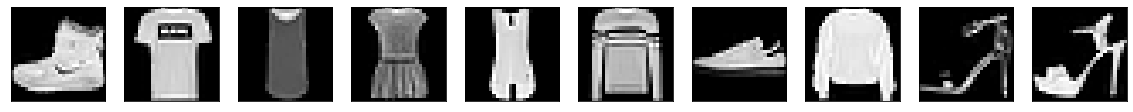

In [4]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_train[index], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
image_size = x_train.shape[1]*x_train.shape[2]
hidden_dim = 512
latent_dim = 10
num_epochs = 80
batch_size = 100
learning_rate = 0.001

In [6]:
class VAE(tf.keras.Model):

    def __init__(self,dim,**kwargs):
        h_dim = dim[0]
        z_dim = dim[1]
        super(VAE, self).__init__(**kwargs)

        self.fc1 = tf.keras.layers.Dense(h_dim)
        self.fc2 = tf.keras.layers.Dense(z_dim)
        self.fc3 = tf.keras.layers.Dense(z_dim)

        self.fc4 = tf.keras.layers.Dense(h_dim)
        self.fc5 = tf.keras.layers.Dense(image_size)

    def encode(self, x):
        h = tf.nn.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = tf.exp(log_var * 0.5)
        eps = tf.random.normal(std.shape)

        return mu + eps * std

    def decode_logits(self, z):
        h = tf.nn.relu(self.fc4(z))
        return self.fc5(h)

    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))

    def call(self, inputs, training=None, mask=None):
        mu, log_var = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        x_reconstructed_logits = self.decode_logits(z)

        return x_reconstructed_logits, mu, log_var

In [7]:
model = VAE([hidden_dim, latent_dim])
model.build(input_shape=(4, image_size))
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate)

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  401920    
_________________________________________________________________
dense_1 (Dense)              multiple                  5130      
_________________________________________________________________
dense_2 (Dense)              multiple                  5130      
_________________________________________________________________
dense_3 (Dense)              multiple                  5632      
_________________________________________________________________
dense_4 (Dense)              multiple                  402192    
Total params: 820,004
Trainable params: 820,004
Non-trainable params: 0
_________________________________________________________________


In [8]:
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(batch_size * 5).batch(batch_size)

num_batches = x_train.shape[0] // batch_size

for epoch in range(num_epochs):

    for step, x in enumerate(dataset):

        x = tf.reshape(x, [-1, image_size])

        with tf.GradientTape() as tape:

            # Forward pass
            x_reconstruction_logits, mu, log_var = model(x)

            # Compute reconstruction loss and kl divergence
            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstruction_logits)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss) / batch_size
            kl_div = - 0.5 * tf.reduce_sum(1. + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
            kl_div = tf.reduce_mean(kl_div)

            # Backprop and optimize
            loss = tf.reduce_mean(reconstruction_loss) + kl_div

        gradients = tape.gradient(loss, model.trainable_variables)
        for g in gradients:
            tf.clip_by_norm(g, 15)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if (step + 1) % 50 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                  .format(epoch + 1, num_epochs, step + 1, num_batches, float(reconstruction_loss), float(kl_div)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch[1/80], Step [50/600], Reconst Loss: 294.8600, KL Div: 14.0198
Epoch[1/80], Step [100/600], Reconst Loss: 291.6082, KL Div: 14.1258
Epoch[1/80], Step [150/600], Reconst Loss: 252.8786, KL Div: 14.9382
Epoch[1/80], Step [200/600], Reconst Loss: 255.8645, KL Div: 12.9271
Epoch[1/80], Step [250/600], Reconst Loss: 254.9781, KL Div: 14.3380
Epoch[1/80], Step [300/600], Reconst Loss: 258.4062, KL Div: 14.7392
Epoch[1/80], Step [350/600], Reconst Loss: 244.1019, KL Div: 15.0542
Epoch[1/80], Step [400/600], Reconst Loss: 240.9099, KL Div: 13.8287
Epoch[1/80], Step [450/600], Reconst Loss: 240.4739, KL Div: 13.7020
Epoch[1/80], Step [500/600], Reconst Loss: 243.7411, KL Div: 13.7590
Epoch[1/80], Step [550/600], Reconst Loss: 240.6016, KL Div: 14.1020
Epoch[1/80], Step [600/600], Reconst Loss: 223.1697, KL Div: 15.4757
Epoch[2/80], Step [50/600], Reconst Loss: 244.8813, KL Div: 14.9065
Epoch[2/80]

Epoch[10/80], Step [400/600], Reconst Loss: 225.7885, KL Div: 15.9701
Epoch[10/80], Step [450/600], Reconst Loss: 226.3832, KL Div: 16.0241
Epoch[10/80], Step [500/600], Reconst Loss: 233.2399, KL Div: 15.0439
Epoch[10/80], Step [550/600], Reconst Loss: 234.0270, KL Div: 15.9009
Epoch[10/80], Step [600/600], Reconst Loss: 224.0077, KL Div: 15.4706
Epoch[11/80], Step [50/600], Reconst Loss: 230.5562, KL Div: 15.1643
Epoch[11/80], Step [100/600], Reconst Loss: 228.2859, KL Div: 14.7181
Epoch[11/80], Step [150/600], Reconst Loss: 230.2280, KL Div: 15.4212
Epoch[11/80], Step [200/600], Reconst Loss: 227.0472, KL Div: 14.8851
Epoch[11/80], Step [250/600], Reconst Loss: 231.6181, KL Div: 15.3818
Epoch[11/80], Step [300/600], Reconst Loss: 225.6627, KL Div: 14.2350
Epoch[11/80], Step [350/600], Reconst Loss: 227.4138, KL Div: 15.3015
Epoch[11/80], Step [400/600], Reconst Loss: 222.6382, KL Div: 14.5104
Epoch[11/80], Step [450/600], Reconst Loss: 227.4146, KL Div: 15.5325
Epoch[11/80], Step [5

Epoch[20/80], Step [300/600], Reconst Loss: 216.4073, KL Div: 15.5108
Epoch[20/80], Step [350/600], Reconst Loss: 217.7237, KL Div: 15.3318
Epoch[20/80], Step [400/600], Reconst Loss: 231.0179, KL Div: 15.0729
Epoch[20/80], Step [450/600], Reconst Loss: 227.7372, KL Div: 14.9825
Epoch[20/80], Step [500/600], Reconst Loss: 227.7420, KL Div: 14.6122
Epoch[20/80], Step [550/600], Reconst Loss: 222.6200, KL Div: 15.2958
Epoch[20/80], Step [600/600], Reconst Loss: 225.2999, KL Div: 16.1211
Epoch[21/80], Step [50/600], Reconst Loss: 217.2043, KL Div: 14.8722
Epoch[21/80], Step [100/600], Reconst Loss: 222.6296, KL Div: 16.3898
Epoch[21/80], Step [150/600], Reconst Loss: 226.7141, KL Div: 15.6371
Epoch[21/80], Step [200/600], Reconst Loss: 215.6023, KL Div: 15.0672
Epoch[21/80], Step [250/600], Reconst Loss: 217.1675, KL Div: 15.4614
Epoch[21/80], Step [300/600], Reconst Loss: 228.6756, KL Div: 14.5369
Epoch[21/80], Step [350/600], Reconst Loss: 228.3686, KL Div: 15.8855
Epoch[21/80], Step [4

Epoch[30/80], Step [200/600], Reconst Loss: 234.6287, KL Div: 15.6719
Epoch[30/80], Step [250/600], Reconst Loss: 219.4107, KL Div: 15.9970
Epoch[30/80], Step [300/600], Reconst Loss: 241.6514, KL Div: 14.5534
Epoch[30/80], Step [350/600], Reconst Loss: 219.6726, KL Div: 14.5252
Epoch[30/80], Step [400/600], Reconst Loss: 224.4201, KL Div: 14.7432
Epoch[30/80], Step [450/600], Reconst Loss: 216.1542, KL Div: 15.3976
Epoch[30/80], Step [500/600], Reconst Loss: 224.0206, KL Div: 16.0678
Epoch[30/80], Step [550/600], Reconst Loss: 221.3311, KL Div: 15.3928
Epoch[30/80], Step [600/600], Reconst Loss: 221.1515, KL Div: 15.1941
Epoch[31/80], Step [50/600], Reconst Loss: 225.7796, KL Div: 16.0006
Epoch[31/80], Step [100/600], Reconst Loss: 222.7178, KL Div: 15.3856
Epoch[31/80], Step [150/600], Reconst Loss: 229.3329, KL Div: 15.1075
Epoch[31/80], Step [200/600], Reconst Loss: 228.4930, KL Div: 14.8662
Epoch[31/80], Step [250/600], Reconst Loss: 229.1513, KL Div: 15.5694
Epoch[31/80], Step [3

Epoch[40/80], Step [100/600], Reconst Loss: 217.2129, KL Div: 15.5538
Epoch[40/80], Step [150/600], Reconst Loss: 224.4528, KL Div: 14.8767
Epoch[40/80], Step [200/600], Reconst Loss: 241.6776, KL Div: 14.6458
Epoch[40/80], Step [250/600], Reconst Loss: 234.5568, KL Div: 15.0631
Epoch[40/80], Step [300/600], Reconst Loss: 220.3762, KL Div: 15.0421
Epoch[40/80], Step [350/600], Reconst Loss: 218.1153, KL Div: 14.8836
Epoch[40/80], Step [400/600], Reconst Loss: 213.8252, KL Div: 15.9797
Epoch[40/80], Step [450/600], Reconst Loss: 224.7205, KL Div: 15.4808
Epoch[40/80], Step [500/600], Reconst Loss: 228.6207, KL Div: 15.3695
Epoch[40/80], Step [550/600], Reconst Loss: 221.4709, KL Div: 15.9363
Epoch[40/80], Step [600/600], Reconst Loss: 220.1657, KL Div: 14.7539
Epoch[41/80], Step [50/600], Reconst Loss: 237.7005, KL Div: 15.6657
Epoch[41/80], Step [100/600], Reconst Loss: 236.8973, KL Div: 15.1609
Epoch[41/80], Step [150/600], Reconst Loss: 215.6556, KL Div: 14.8893
Epoch[41/80], Step [2

Epoch[49/80], Step [600/600], Reconst Loss: 242.8629, KL Div: 14.8794
Epoch[50/80], Step [50/600], Reconst Loss: 220.3703, KL Div: 15.6066
Epoch[50/80], Step [100/600], Reconst Loss: 216.9826, KL Div: 14.8425
Epoch[50/80], Step [150/600], Reconst Loss: 229.9801, KL Div: 16.0906
Epoch[50/80], Step [200/600], Reconst Loss: 208.8636, KL Div: 14.7475
Epoch[50/80], Step [250/600], Reconst Loss: 223.2682, KL Div: 15.0819
Epoch[50/80], Step [300/600], Reconst Loss: 217.0771, KL Div: 15.0012
Epoch[50/80], Step [350/600], Reconst Loss: 220.2097, KL Div: 15.6120
Epoch[50/80], Step [400/600], Reconst Loss: 214.5755, KL Div: 14.9468
Epoch[50/80], Step [450/600], Reconst Loss: 227.2109, KL Div: 15.9642
Epoch[50/80], Step [500/600], Reconst Loss: 219.3345, KL Div: 15.0749
Epoch[50/80], Step [550/600], Reconst Loss: 225.4042, KL Div: 15.0492
Epoch[50/80], Step [600/600], Reconst Loss: 230.2405, KL Div: 15.5447
Epoch[51/80], Step [50/600], Reconst Loss: 226.4652, KL Div: 14.8958
Epoch[51/80], Step [10

Epoch[59/80], Step [500/600], Reconst Loss: 244.7207, KL Div: 15.1725
Epoch[59/80], Step [550/600], Reconst Loss: 234.4637, KL Div: 15.3538
Epoch[59/80], Step [600/600], Reconst Loss: 222.8686, KL Div: 16.2839
Epoch[60/80], Step [50/600], Reconst Loss: 234.4224, KL Div: 15.2024
Epoch[60/80], Step [100/600], Reconst Loss: 219.8748, KL Div: 15.6019
Epoch[60/80], Step [150/600], Reconst Loss: 226.0905, KL Div: 15.2891
Epoch[60/80], Step [200/600], Reconst Loss: 228.8453, KL Div: 15.6129
Epoch[60/80], Step [250/600], Reconst Loss: 236.7935, KL Div: 15.3096
Epoch[60/80], Step [300/600], Reconst Loss: 229.0162, KL Div: 15.0723
Epoch[60/80], Step [350/600], Reconst Loss: 229.0191, KL Div: 15.3547
Epoch[60/80], Step [400/600], Reconst Loss: 227.7527, KL Div: 15.4549
Epoch[60/80], Step [450/600], Reconst Loss: 222.8627, KL Div: 15.1654
Epoch[60/80], Step [500/600], Reconst Loss: 220.0172, KL Div: 15.3194
Epoch[60/80], Step [550/600], Reconst Loss: 218.7097, KL Div: 15.0155
Epoch[60/80], Step [6

Epoch[69/80], Step [400/600], Reconst Loss: 228.9365, KL Div: 15.3566
Epoch[69/80], Step [450/600], Reconst Loss: 207.8805, KL Div: 14.8201
Epoch[69/80], Step [500/600], Reconst Loss: 222.4449, KL Div: 15.6873
Epoch[69/80], Step [550/600], Reconst Loss: 221.1747, KL Div: 15.1234
Epoch[69/80], Step [600/600], Reconst Loss: 218.9840, KL Div: 16.1893
Epoch[70/80], Step [50/600], Reconst Loss: 223.7026, KL Div: 16.2849
Epoch[70/80], Step [100/600], Reconst Loss: 228.6252, KL Div: 15.3827
Epoch[70/80], Step [150/600], Reconst Loss: 234.6234, KL Div: 15.4745
Epoch[70/80], Step [200/600], Reconst Loss: 233.8750, KL Div: 15.4892
Epoch[70/80], Step [250/600], Reconst Loss: 219.5835, KL Div: 14.4313
Epoch[70/80], Step [300/600], Reconst Loss: 215.7886, KL Div: 16.2036
Epoch[70/80], Step [350/600], Reconst Loss: 230.1521, KL Div: 15.0495
Epoch[70/80], Step [400/600], Reconst Loss: 230.8018, KL Div: 15.5763
Epoch[70/80], Step [450/600], Reconst Loss: 222.8168, KL Div: 15.5422
Epoch[70/80], Step [5

Epoch[79/80], Step [300/600], Reconst Loss: 224.8697, KL Div: 15.7195
Epoch[79/80], Step [350/600], Reconst Loss: 237.1901, KL Div: 16.1994
Epoch[79/80], Step [400/600], Reconst Loss: 214.4866, KL Div: 15.0840
Epoch[79/80], Step [450/600], Reconst Loss: 226.6395, KL Div: 15.5873
Epoch[79/80], Step [500/600], Reconst Loss: 220.9902, KL Div: 15.1013
Epoch[79/80], Step [550/600], Reconst Loss: 228.2453, KL Div: 16.0226
Epoch[79/80], Step [600/600], Reconst Loss: 227.3730, KL Div: 15.9242
Epoch[80/80], Step [50/600], Reconst Loss: 220.4270, KL Div: 15.7162
Epoch[80/80], Step [100/600], Reconst Loss: 221.9150, KL Div: 15.4102
Epoch[80/80], Step [150/600], Reconst Loss: 218.8242, KL Div: 15.8331
Epoch[80/80], Step [200/600], Reconst Loss: 238.7164, KL Div: 15.4126
Epoch[80/80], Step [250/600], Reconst Loss: 231.0200, KL Div: 15.5817
Epoch[80/80], Step [300/600], Reconst Loss: 214.9100, KL Div: 15.2734
Epoch[80/80], Step [350/600], Reconst Loss: 228.7933, KL Div: 15.4659
Epoch[80/80], Step [4

In [9]:
z = tf.random.normal((batch_size, latent_dim))
out = model.decode(z)  # decode with sigmoid
out = tf.reshape(out, [-1, 28, 28]).numpy() * 255
out = out.astype(np.uint8)

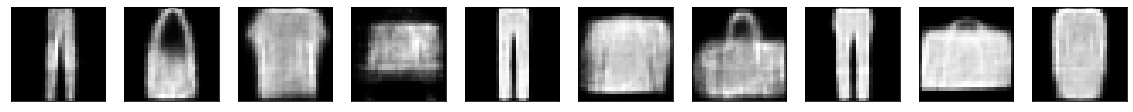

In [10]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(out[index], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()